# Method
On first look at the dataset, I cam to the understanding that we needed to create a network graph, with the following arrangements:

  a. Graph type: `Undirected Simple`, therefore useing NetworkX `Graph` class. To begin analysing, and to simplify the start prcess, I have decided not to make use of directional information (`StartJunction` --> `EndJunction`), and focus only on the analysis of :
- measuring link utilisation per year for each category of transport
- average speed of the road, and change over years
- latency (delay) - when looking through the whole road - where are the slow sections, and how does this change each year 
- path bandwidth (overall traffic / per vehicle category)/ reliability
 

The dataset contains data about each road segment over a 17 year period. All of the data is together, so we need a way of being able to distinguish the same segment of road each year, in order to analyse relevent information, like traffic type changes over year...etc.

Creating a NetworkX Graph object, it takes in a hashable node. In graph theory, a node is an intersecting point, or vertex, where 0 or more edges  meet.

## Splitting the dataset

Using this information, and relating it to the dataset; each road can be seen as an `edge`; and the entry in the table `StartJunction` and `EndJunction` are the correstponding $v$ and $w$ nodes.

This picture does not give an exact representation, as it means that the individual junction entries often have more than one junction listed eg: an entry junction `'A124/A1083'` which means that it is linked to two roads; but for the time being, this is enough to begin analysing.

Each row entry in the dataset is the information about that particular year, so we can also split up the data for that particular road segment over years: structuring the data like so:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from src import get_region_df

london_df = get_region_df('London.csv')
year_range = london_df['AADFYear'].unique()
hashes = london_df['road_section_hash'].unique()

print(london_df.dtypes)
# london_df.head()

AADFYear                        int64
CP                              int64
Estimation_method              object
Estimation_method_detailed     object
Region                         object
LocalAuthority                 object
Road                           object
RoadCategory                   object
Easting                         int64
Northing                        int64
StartJunction                  object
EndJunction                    object
LinkLength_km                 float64
LinkLength_miles              float64
PedalCycles                     int64
Motorcycles                     int64
CarsTaxis                       int64
BusesCoaches                    int64
LightGoodsVehicles              int64
V2AxleRigidHGV                  int64
V3AxleRigidHGV                  int64
V4or5AxleRigidHGV               int64
V3or4AxleArticHGV               int64
V5AxleArticHGV                  int64
V6orMoreAxleArticHGV            int64
AllHGVs                         int64
AllMotorVehi

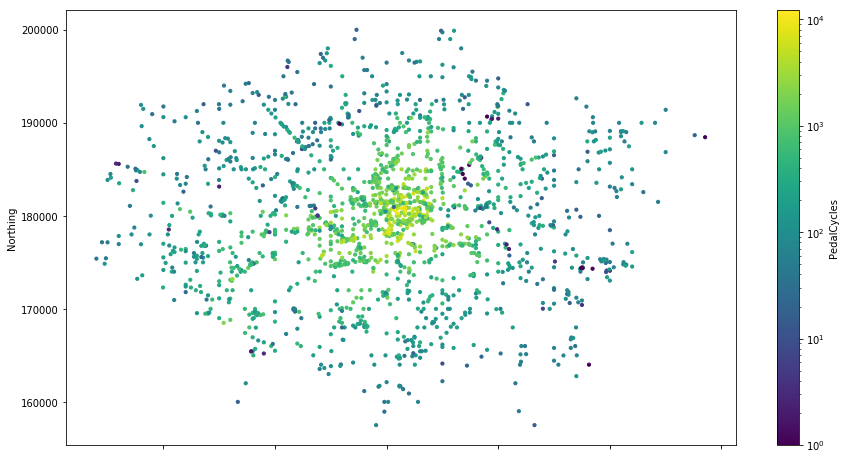

In [2]:
from matplotlib import colors
pedals_min = london_df['PedalCycles'].min()+1
pedals_max=london_df['PedalCycles'].max()

london_df[london_df['AADFYear']==2017].plot.scatter(
    x='Easting',
    y='Northing',
    figsize=(15,8),
    s=10,
    c='PedalCycles',
    cmap=plt.get_cmap('viridis'),
    norm=colors.LogNorm(vmin=pedals_min, vmax=pedals_max)
)

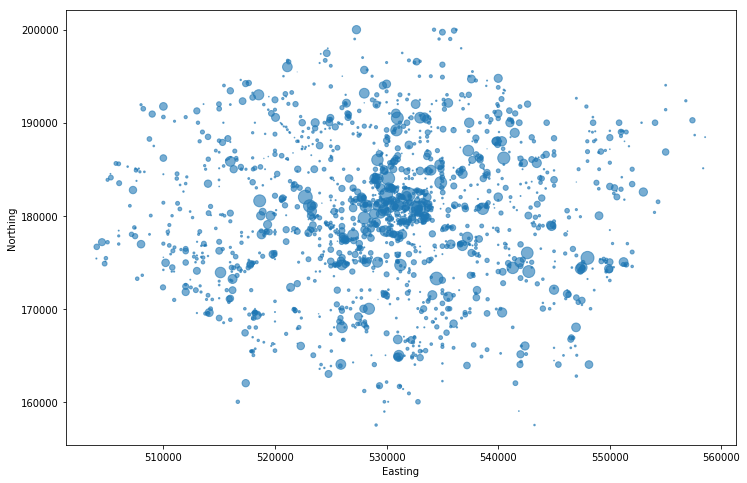

In [3]:
# Show the busiest roads of a specific type of traffic for a specific year ()
london_df[london_df['AADFYear']==2017].plot.scatter(x='Easting', y='Northing', figsize=(12,8), s=london_df.PedalCycles/20, alpha=0.6)

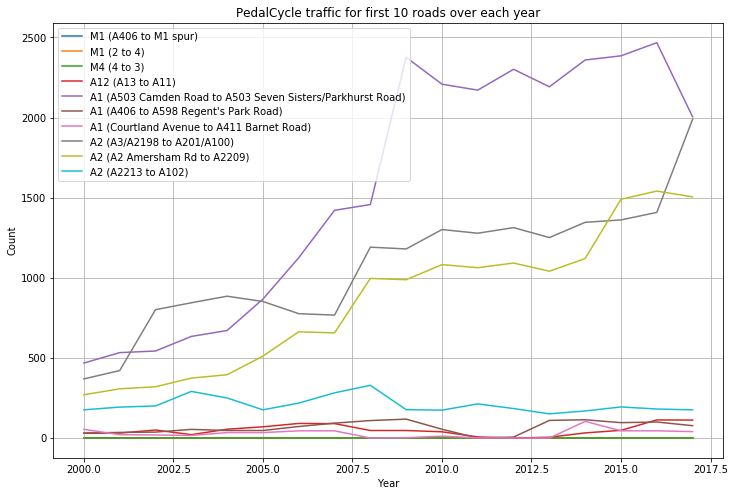

In [4]:
from src import get_cat_year_data, get_year_data, hash_single, hash_to_name


plt.figure(figsize=(12,8))
for h in hashes[0:10]:
    name = '{}'.format(hash_to_name(london_df, h))
    year_range, collected = get_year_data(london_df, h, 'PedalCycles')
    plt.plot(year_range, collected, label=name)
plt.grid()
plt.title('PedalCycle traffic for first 10 roads over each year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()

Measuring Pedal Cycle usage with the highest ratio of HGVs to Pedal Cycles.


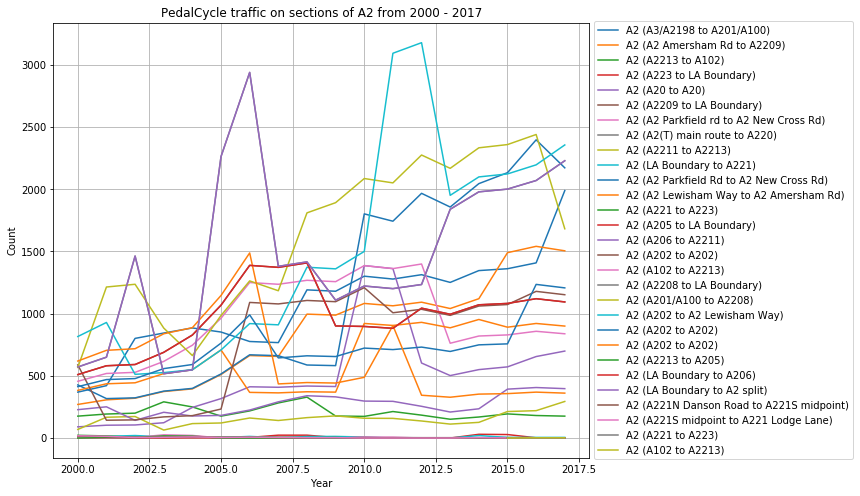

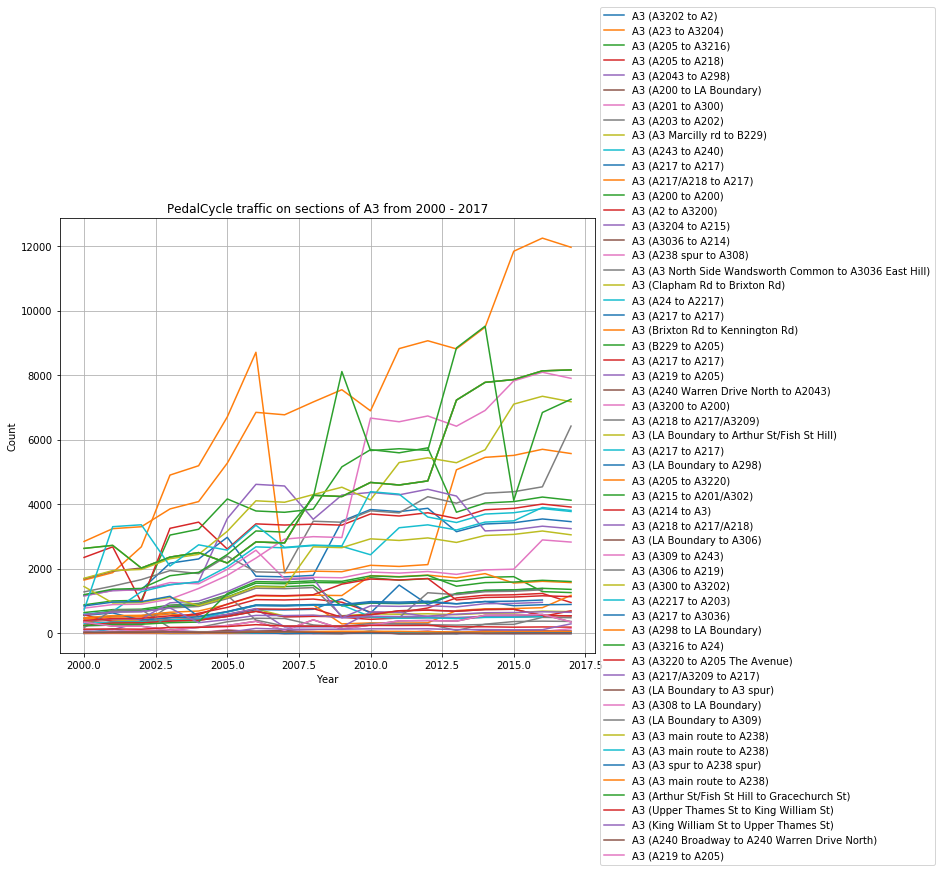

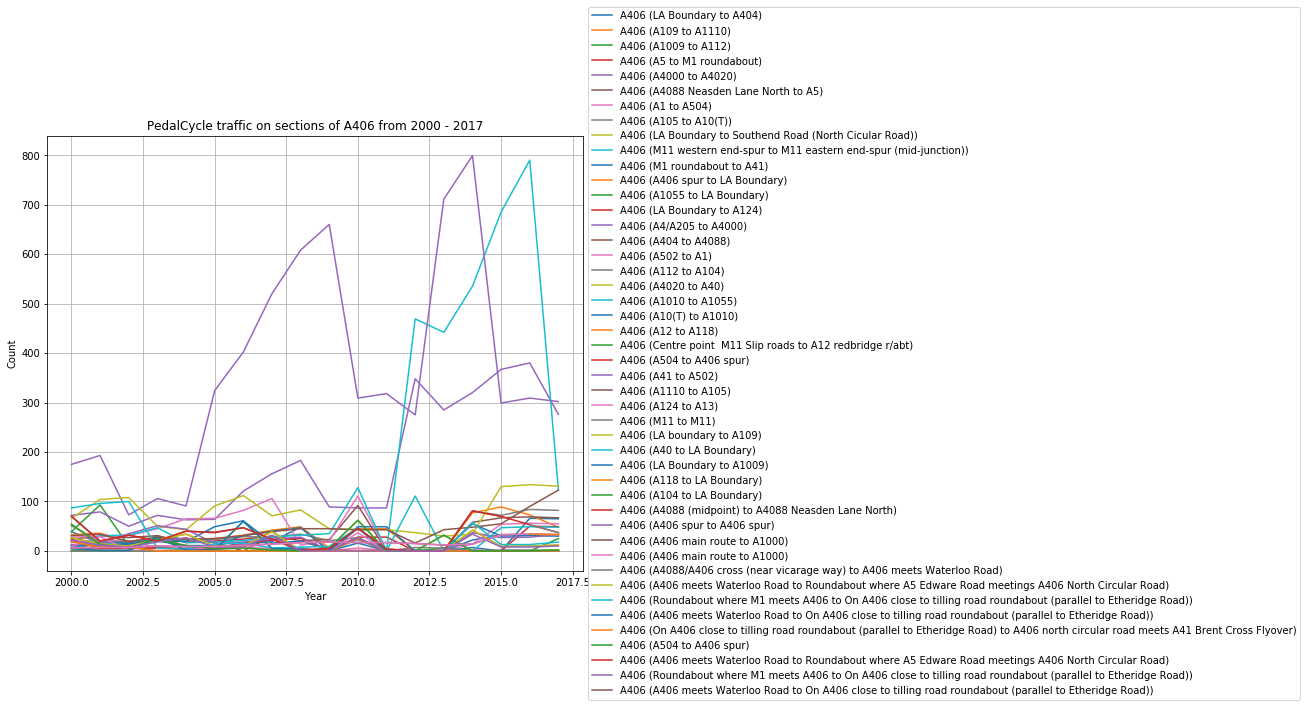

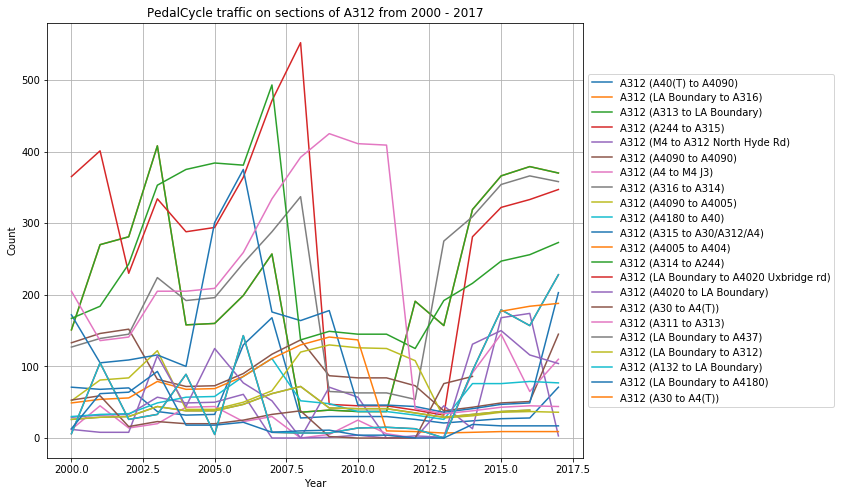

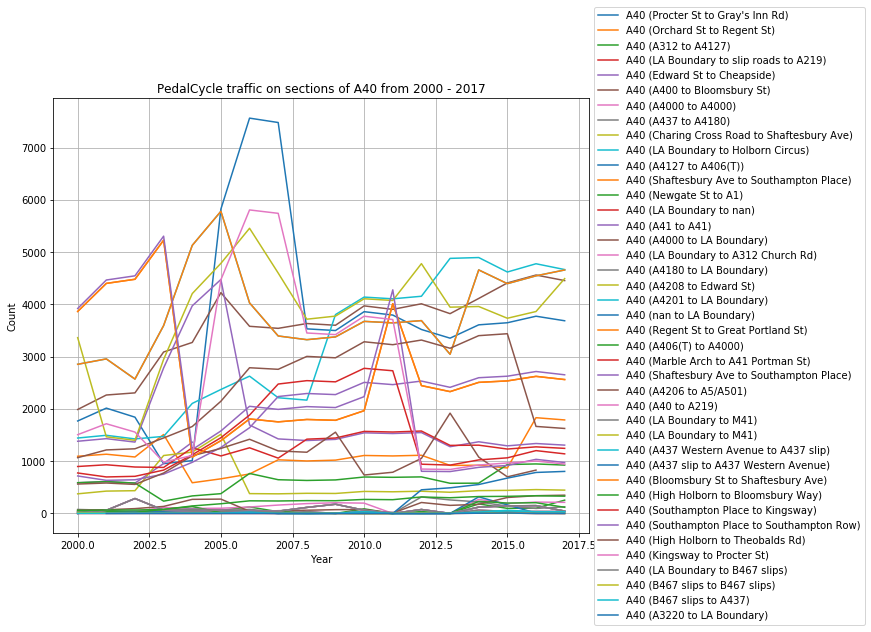

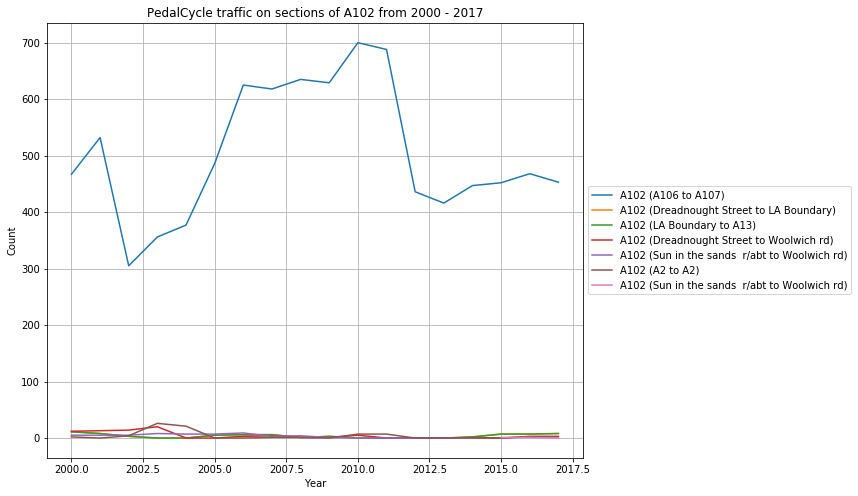

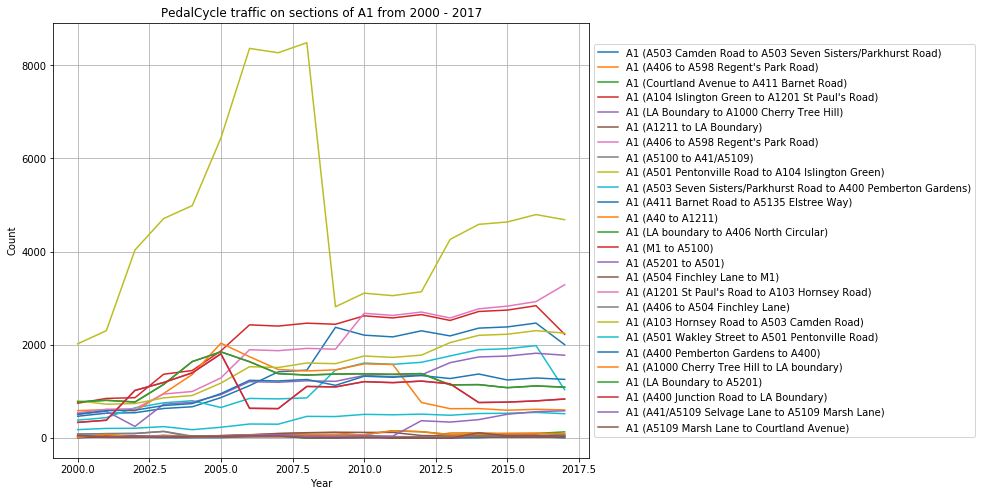

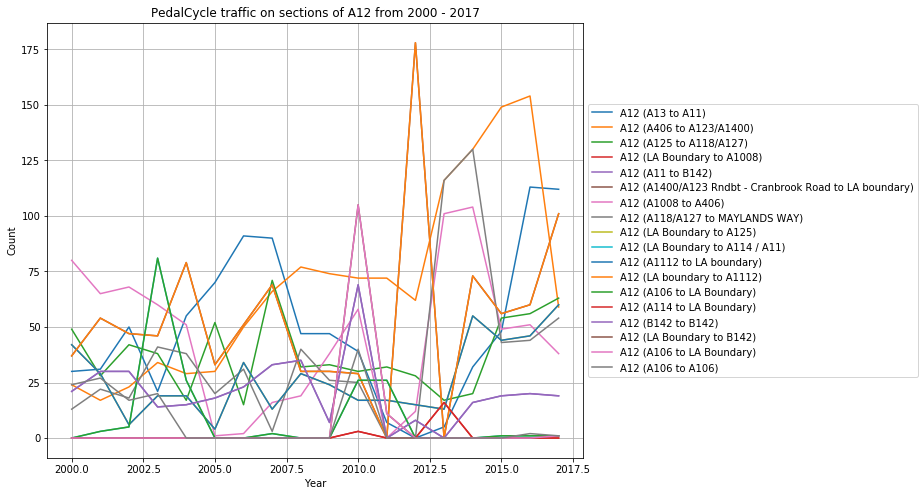

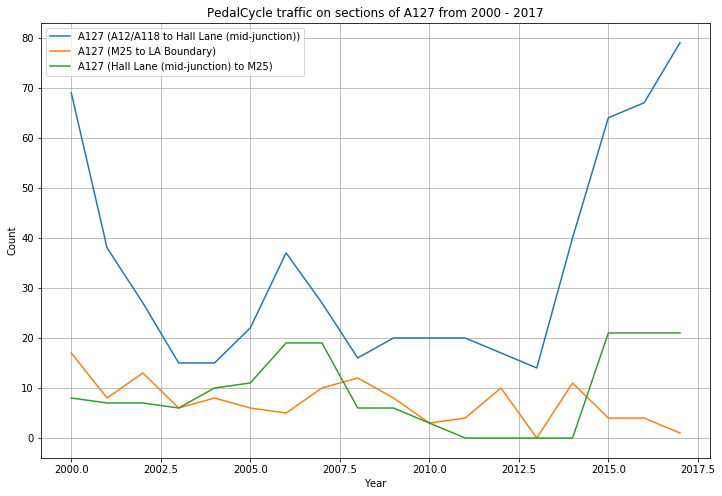

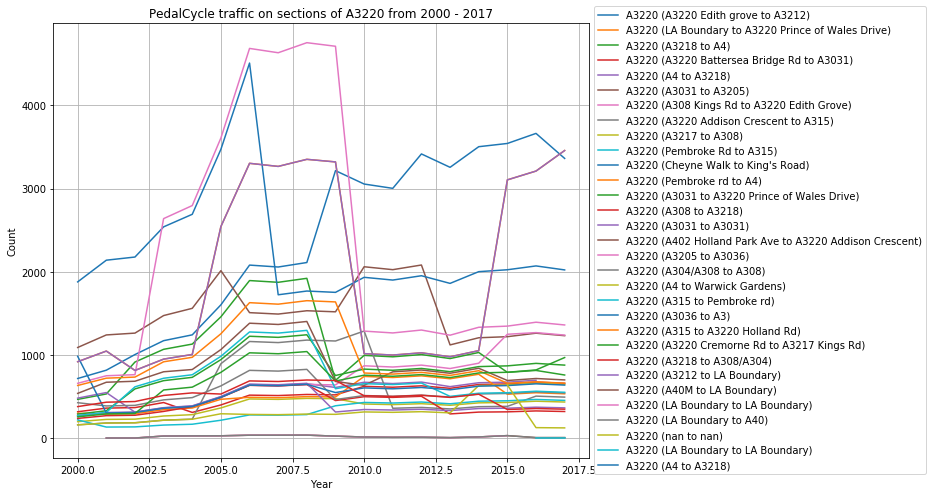

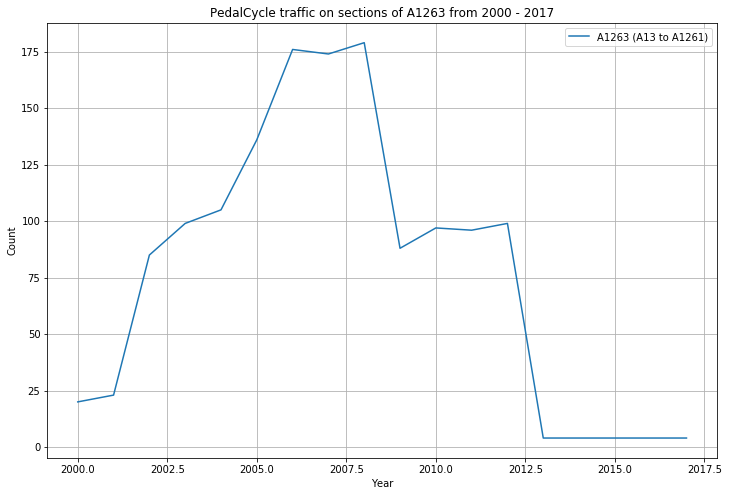

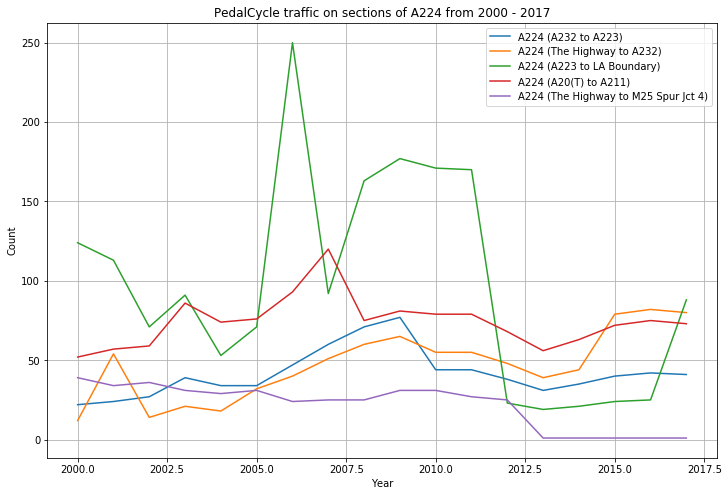

In [5]:
from src import filter_collect, plot_per_year

# Find all the segments of a road (eg A1), then make different plots for each of those values over time

heavy_split_df = london_df[(london_df['AADFYear']==2017) & (london_df['PedalCycles']>0)][['Road','PedalCycles','AllHGVs']]
heavy_split_df['heavy'] = heavy_split_df['AllHGVs']/heavy_split_df['PedalCycles']
danger_level = heavy_split_df['heavy'].describe([0.98])[-2]
road_list = heavy_split_df[heavy_split_df['heavy']>=danger_level].Road.unique()
print("Measuring Pedal Cycle usage with the highest ratio of HGVs to Pedal Cycles.")
for i, road in enumerate(road_list):
    R = london_df[london_df['Road']==road]
    plot_per_year(R, 'PedalCycles', 'PedalCycle traffic on sections of {} from 2000 - 2017'.format(road))

To see most popular pedal along A routes, using a geographical map:
First take a look at the range of values in most recent year

Roads with heavy cycle usage:  987.0


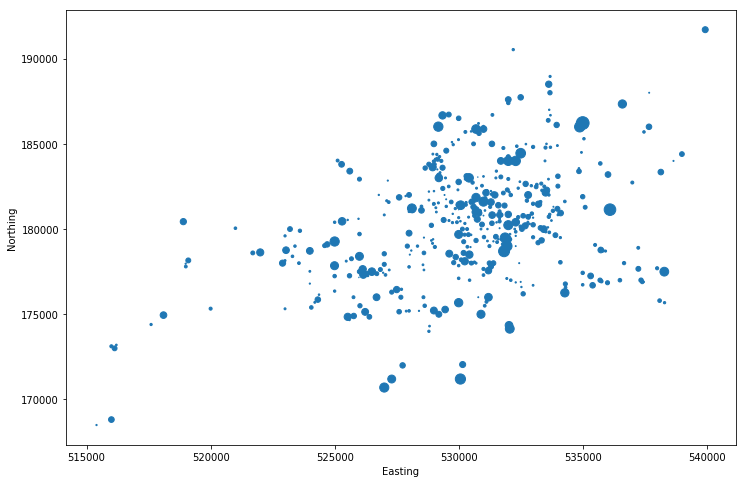

In [6]:
heavy_split = london_df[london_df['AADFYear']==2017][['PedalCycles']].describe()
heavy_val = heavy_split.values[-2][0] # The values of 75%
print('Roads with heavy cycle usage: ', heavy_val)
heavy_PedalCycles2017 = london_df[ (london_df['AADFYear']==2017) & (london_df['PedalCycles']>= heavy_val) ]
# heavy_PedalCycles2017
heavy_PedalCycles2017.plot.scatter(x='Easting', y='Northing', figsize=(12,8), s=london_df.PedalCycles/20)

/Users/samuel/.virtualenvs/redoptima/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


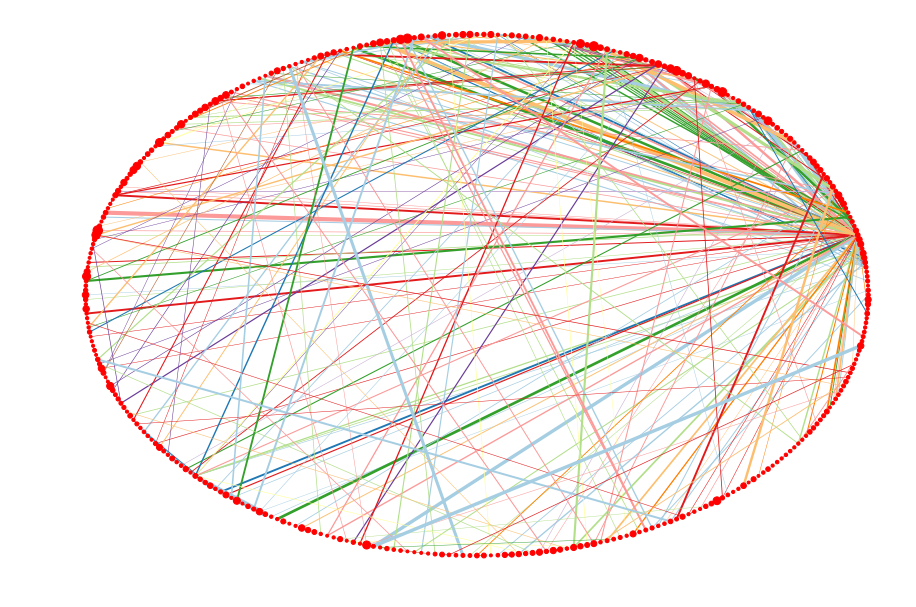

In [7]:
from networkx.drawing.nx_agraph import graphviz_layout
from src import net_graph, unique_everseen, li2n, get_edge_weights
    

NX_pedals = net_graph(heavy_PedalCycles2017)

# x = nx.get_edge_attributes(NX_pedals, 'Easting')
# y = nx.get_edge_attributes(NX_pedals, 'Northing')

edges = NX_pedals.edges()
road_list = [NX_pedals[u][v]['Road'] for u,v in edges]
colours_dict = li2n(road_list)
colours = []
for road in road_list:
#     Make each 'Road' attribute a different colour
    colours.append(colours_dict[road])


weights = get_edge_weights(NX_pedals, 'PedalCycles', edges)
normalised_weights = weights/np.sort(weights)[-1]

# print(colors)
plt.figure(figsize=(12,8))

nx.draw_shell(
    NX_pedals,
    edges=edges,
    edge_color=colours,
    width=5*normalised_weights,
    edge_cmap=plt.cm.Paired,
    node_size=100*normalised_weights,
    )

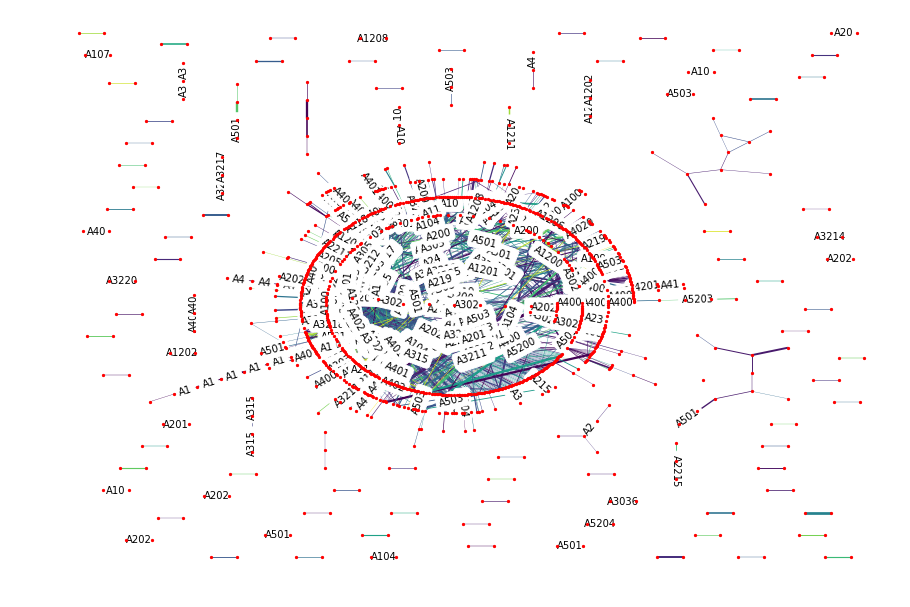

In [8]:
plt.figure(figsize=(12,8))

all_PedalCycles2017 = london_df[ (london_df['AADFYear']==2017) & (london_df['PedalCycles']>= 0) ]
heavy_PedalCycles2017 = london_df[ (london_df['PedalCycles']>= heavy_val) ]

NX_all_pedals = net_graph(all_PedalCycles2017)
NX_heavy_pedals = net_graph(heavy_PedalCycles2017)

pos_all = graphviz_layout( NX_all_pedals, prog='twopi')
# pos_all = nx.layout.random_layout( NX_all_pedals)

edges = NX_all_pedals.edges()
road_list = [NX_all_pedals[u][v]['Road'] for u,v in edges]
colours_dict = li2n(road_list)
colours = []
for road in road_list:
#     Make each 'Road' attribute a different colour
    colours.append(colours_dict[road])
    
labels = {}
edge_attrs_cycles = nx.get_edge_attributes(NX_all_pedals, 'PedalCycles') 
edge_attrs_road = nx.get_edge_attributes(NX_all_pedals, 'Road') 
for edge in edges:
    if edge_attrs_cycles[edge]>= heavy_val:
#         only show 'heavy' road usage
        labels[edge] = edge_attrs_road[edge]

nx.draw(
    NX_all_pedals,
    edges=edges,
    edge_color=colours,
    width=3*normalised_weights,
#     edge_cmap=plt.cm.Paired,
    node_size=5,
    pos=pos_all)
nx.draw_networkx_edge_labels(NX_heavy_pedals,pos=pos_all,edge_labels=labels);


In [2]:
# def create_graph(df, G=nx.Graph):
#     for road in yearly_df.Road.unique():
#         road_df = yearly_df[yearly_df['Road']==road]
#         R_Y = nx.from_pandas_edgelist(road_df, source='StartJunction',target='EndJunction', edge_attr=True)
#         Y.add_nodes_from(R_Y.nodes, year=year)
#     return G
        
    
from src import net_graph, drw_graph_filtered, drw_graph
        
# def drw_graph_filtered(df,year,filter_col,cutoff):
    
#     df_all = df[ (df['AADFYear']==year) & (df[filter_col]>= 0) ]
#     df_filt = df[ (df[filter_col]>= cutoff) ]

#     NX_all = net_graph(df_all)
#     NX_heavy = net_graph(df_filt)

#     pos_all = graphviz_layout( NX_all, prog='twopi')

#     edges = NX_all.edges()
#     road_list = [NX_all[u][v]['Road'] for u,v in edges]
#     colours_dict = li2n(road_list)
#     colours = []
#     for road in road_list:
#     #     Make each 'Road' attribute a different colour
#         colours.append(colours_dict[road])

#     labels = {}
#     edge_attrs_cycles = nx.get_edge_attributes(NX_all, filter_col) 
#     edge_attrs_road = nx.get_edge_attributes(NX_all, 'Road') 
#     for edge in edges:
#         if edge_attrs_cycles[edge]>= heavy_val:
#     #         only show 'heavy' road usage
#             labels[edge] = edge_attrs_road[edge]

#     nx.draw(
#         NX_all_pedals,
#         edges=edges,
#         edge_color=colours,
#         width=3*normalised_weights,
#     #     edge_cmap=plt.cm.Paired,
#         node_size=5,
#         pos=pos_all)
    
# def drw_graph(G,weight_attr):
#     """
#     line_weight: column name for 
#     """
#     edges = G.edges()
#     road_list = [G[u][v]['Road'] for u,v in edges]
#     colors_dict = li2n(road_list)
#     colours = []
#     for road in road_list:
#         colours.append(colors_dict[road])
        
#     weights = get_edge_weights(G, 'PedalCycles', edges)
#     normalised_weights = weights/np.sort(weights)[-1]
    
#     nx.draw(
#         G,
#         edges=edges,
#         edge_color=colours,
#         width=15*normalised_weights,
#         edge_cmap=plt.cm.Paired,
#         node_size=10,
#         pos=pos
#     )

plt.figure('Car traffic on M1 over years')
for i, year in enumerate(london_df.AADFYear.unique()[0:3]):
    yearly_df = london_df[london_df['AADFYear']==year]
    Y = net_graph(yearly_df)
    drw_graph(Y, 'PedalCycles',None)

# G = create_graph(london_df)
# drw_graph_years(G)

ImportError: cannot import name 'drw_graph_filtered' from 'src' (/Users/samuel/src/redoptima/src.py)